In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import holidays
import scipy.stats as stats
import sklearn.model_selection as ms

In [2]:
# This section takes a few minutes to run.

pc = pd.read_csv('pc_rmna.csv', low_memory = False)

## convert to datetime format
pc['timestamp'] = pc.apply(lambda x: datetime.datetime.strptime(x['Date'].split('/')[2] + '/' + x['Date'].split('/')[1] + '/' + x['Date'].split('/')[0] + ' ' + x['Time'], "%Y/%m/%d %H:%M:%S"), axis = 1)
print('done with timestamp')
pc['date'] = pc.apply(lambda x: datetime.datetime.strptime(x['Date'].split('/')[2] + '-' + x['Date'].split('/')[1] + '-' + x['Date'].split('/')[0], '%Y-%m-%d'), axis = 1)
print('done with date')
pc['time'] = pc.apply(lambda x: datetime.datetime.strptime(x['Time'], '%H:%M:%S'), axis = 1)
print('done with time')

#print(pc)




done with timestamp
done with date
done with time


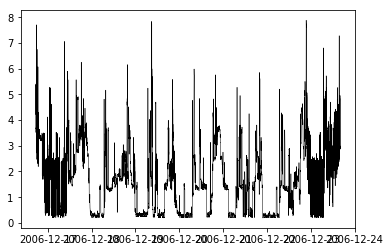

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


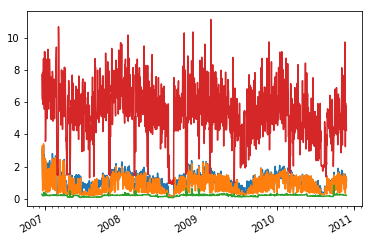

In [3]:
plt.plot(pc[:10000]['timestamp'], pc[:10000]['Global_active_power'], 'k', linewidth = 0.5)
plt.show()

# So it looks like there are too many datapoints to get a clear graph over
# a longer period of time. What I will do is plot daily max, min, average,
# and median values. This will give me a clearer view of any cyclical trends.

fig, ax = plt.subplots()

pc_plot = pc[['date', 'Global_active_power']].groupby(['date']).mean().reset_index().rename(index = str, columns = {"Global_active_power": "mean_active_power"})
pc_plot = pc_plot.merge(pc[['date', 'Global_active_power']].groupby(['date']).median().reset_index().rename(index = str, columns = {"Global_active_power": "median_active_power"}), on = 'date', how = 'inner')
pc_plot = pc_plot.merge(pc[['date', 'Global_active_power']].groupby(['date']).min().reset_index().rename(index = str, columns = {"Global_active_power": "min_active_power"}), on = 'date', how = 'inner')
pc_plot = pc_plot.merge(pc[['date', 'Global_active_power']].groupby(['date']).max().reset_index().rename(index = str, columns = {"Global_active_power": "max_active_power"}), on = 'date', how = 'inner')

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.plot(pc_plot['date'], pc_plot[['mean_active_power', 'median_active_power', 'min_active_power', 'max_active_power']])
fig.autofmt_xdate()
plt.rcParams["figure.figsize"] = [60, 20]

fig.savefig('cyclical_power.png')
fig.show()

# If the plots don't show up nicely, rerun this section.



In [7]:
# This section runs for several minutes.

# The power consumption clearly follows a cyclical, seasonal
# pattern. The median, mean, and max lines show this trend.

# I need to extract features that will account for seasonal
# variation. I'll start with months. I'll also try seasons
# separately to see which will work better.

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)

seasons = [('winter', (datetime.date(Y, 1, 1), datetime.date(Y, 3, 20))),
           ('spring', (datetime.date(Y, 3, 21), datetime.date(Y, 6, 20))),
           ('summer', (datetime.date(Y, 6, 21), datetime.date(Y, 9, 22))),
           ('fall', (datetime.date(Y, 9, 23),  datetime.date(Y, 12, 20))),
           ('winter', (datetime.date(Y, 12, 21),  datetime.date(Y, 12, 31)))]

def get_season(date):
    date = datetime.datetime.date(date)
    date = date.replace(year = Y)
    return next(season for season, (start, end) in seasons
                if start <= date <= end)

pc['winter'] = [1 if get_season(a) == 'winter' else 0 for a in pc['date']]
pc['spring'] = [1 if get_season(a) == 'spring' else 0 for a in pc['date']]
pc['summer'] = [1 if get_season(a) == 'summer' else 0 for a in pc['date']]
pc['fall'] = [1 if get_season(a) == 'fall' else 0 for a in pc['date']]

print('Done with seasons...')

# I need to make dummy variable for the months instead of
# month numbers because there is no linear relationship
# between one month to the next as seen in the plot.

pc['jan'] = [1 if a.month == 1 else 0 for a in pc['date']]
pc['feb'] = [1 if a.month == 2 else 0 for a in pc['date']]
pc['mar'] = [1 if a.month == 3 else 0 for a in pc['date']]
pc['apr'] = [1 if a.month == 4 else 0 for a in pc['date']]
pc['may'] = [1 if a.month == 5 else 0 for a in pc['date']]
pc['jun'] = [1 if a.month == 6 else 0 for a in pc['date']]
pc['jul'] = [1 if a.month == 7 else 0 for a in pc['date']]
pc['aug'] = [1 if a.month == 8 else 0 for a in pc['date']]
pc['sep'] = [1 if a.month == 9 else 0 for a in pc['date']]
pc['oct'] = [1 if a.month == 10 else 0 for a in pc['date']]
pc['nov'] = [1 if a.month == 11 else 0 for a in pc['date']]
pc['dec'] = [1 if a.month == 12 else 0 for a in pc['date']]

print('Done with months...')

# Power consumption dips in the late summer. This suggests
# that the household does not use air conditioning
# extensively and also suggests that the household probably 
# uses some sort of electric heating in the winter. If I were
# building this model in real life, I would try to include
# contemporaneous weather forecasts in the model.

# I wonder if power consumption is different for weekends 
# versus weekdays. There's also a chance that power consumption
# varies depending on whether that day is a federal holiday
# or not.

# There are a few periods of time in which the max power 
# consumption experiences a huge dropoff. These are probably
# the periods of time in which data is missing.

Done with seasons...
Done with months...


In [9]:
# T-tests to check for power differences based on
# weekends/weekdays and holidays/non-holidays:

us_holidays = holidays.UnitedStates()
pc_plot['holiday'] = [1 if a in us_holidays else 0 for a in pc_plot['date']]

print('There are only ' + str(len(pc_plot[pc_plot['holiday'] == 1])) + ' holidays.')

pc_non_holiday = pc_plot['mean_active_power'][pc_plot['holiday'] == 0].sample(n = 43)
pc_holiday = pc_plot['mean_active_power'][pc_plot['holiday'] == 1]

print('The non-holiday mean active power variance is ' + str(np.var(pc_non_holiday)) + 
      ' while the mean active power variance for holidays is ' + str(np.var(pc_holiday)) + '.')
print('If you run this code many times, you will see that the variances are actually not that far off.')
print('The p-value for the independent t-test is ' + str(stats.ttest_ind(pc_non_holiday, pc_holiday).pvalue) + 
      ', suggesting that holidays and non-holidays probably are not from different populations.' + 
      ' Run this code many times, and you will see that the p-value mostly remains above 0.05.\n')

# I'm going to include holidays as a feature, but as shown
# by the t-test, it probably won't be a strong predictor of
# power consumption.

pc_plot['weekday'] = [1 if a.weekday() < 5 else 0 for a in pc_plot['date']]

pc_weekday = pc_plot['mean_active_power'][pc_plot['weekday'] == 1].sample(n = 200)
pc_weekend = pc_plot['mean_active_power'][pc_plot['weekday'] == 0].sample(n = 200)

print('The weekday mean active power variance is ' + str(np.var(pc_weekday)) + 
      ' while the mean active power variance for weekends is ' + str(np.var(pc_weekend)) + '.')
print('If you run this code many times, you will see that the weekday variance is less than the weekend variance.')
print('The p-value for the independent t-test is ' + str(stats.ttest_ind(pc_weekday, pc_weekend).pvalue) + 
      ', suggesting that weekdays and weekends are almost certainly from different populations.' + 
      ' Run this code many times, and you will see that the p-value always remains below 0.05.\n')

# I will definitely create a weekend feature because based
# on the t-test, whether a particular day is a weekday or
# weekend should have a significant impact on power consumption.


There are only 43 holidays.
The non-holiday mean active power variance is 0.24819720154008343 while the mean active power variance for holidays is 0.1320577958484967.
If you run this code many times, you will see that the variances are actually not that far off.
The p-value for the independent t-test is 0.5327999001154138, suggesting that holidays and non-holidays probably are not from different populations. Run this code many times, and you will see that the p-value mostly remains above 0.05.

The weekday mean active power variance is 0.11389567208039755 while the mean active power variance for weekends is 0.24088903327921.
If you run this code many times, you will see that the weekday variance is less than the weekend variance.
The p-value for the independent t-test is 1.4164044537766741e-05, suggesting that weekdays and weekends are almost certainly from different populations. Run this code many times, and you will see that the p-value always remains below 0.05.



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


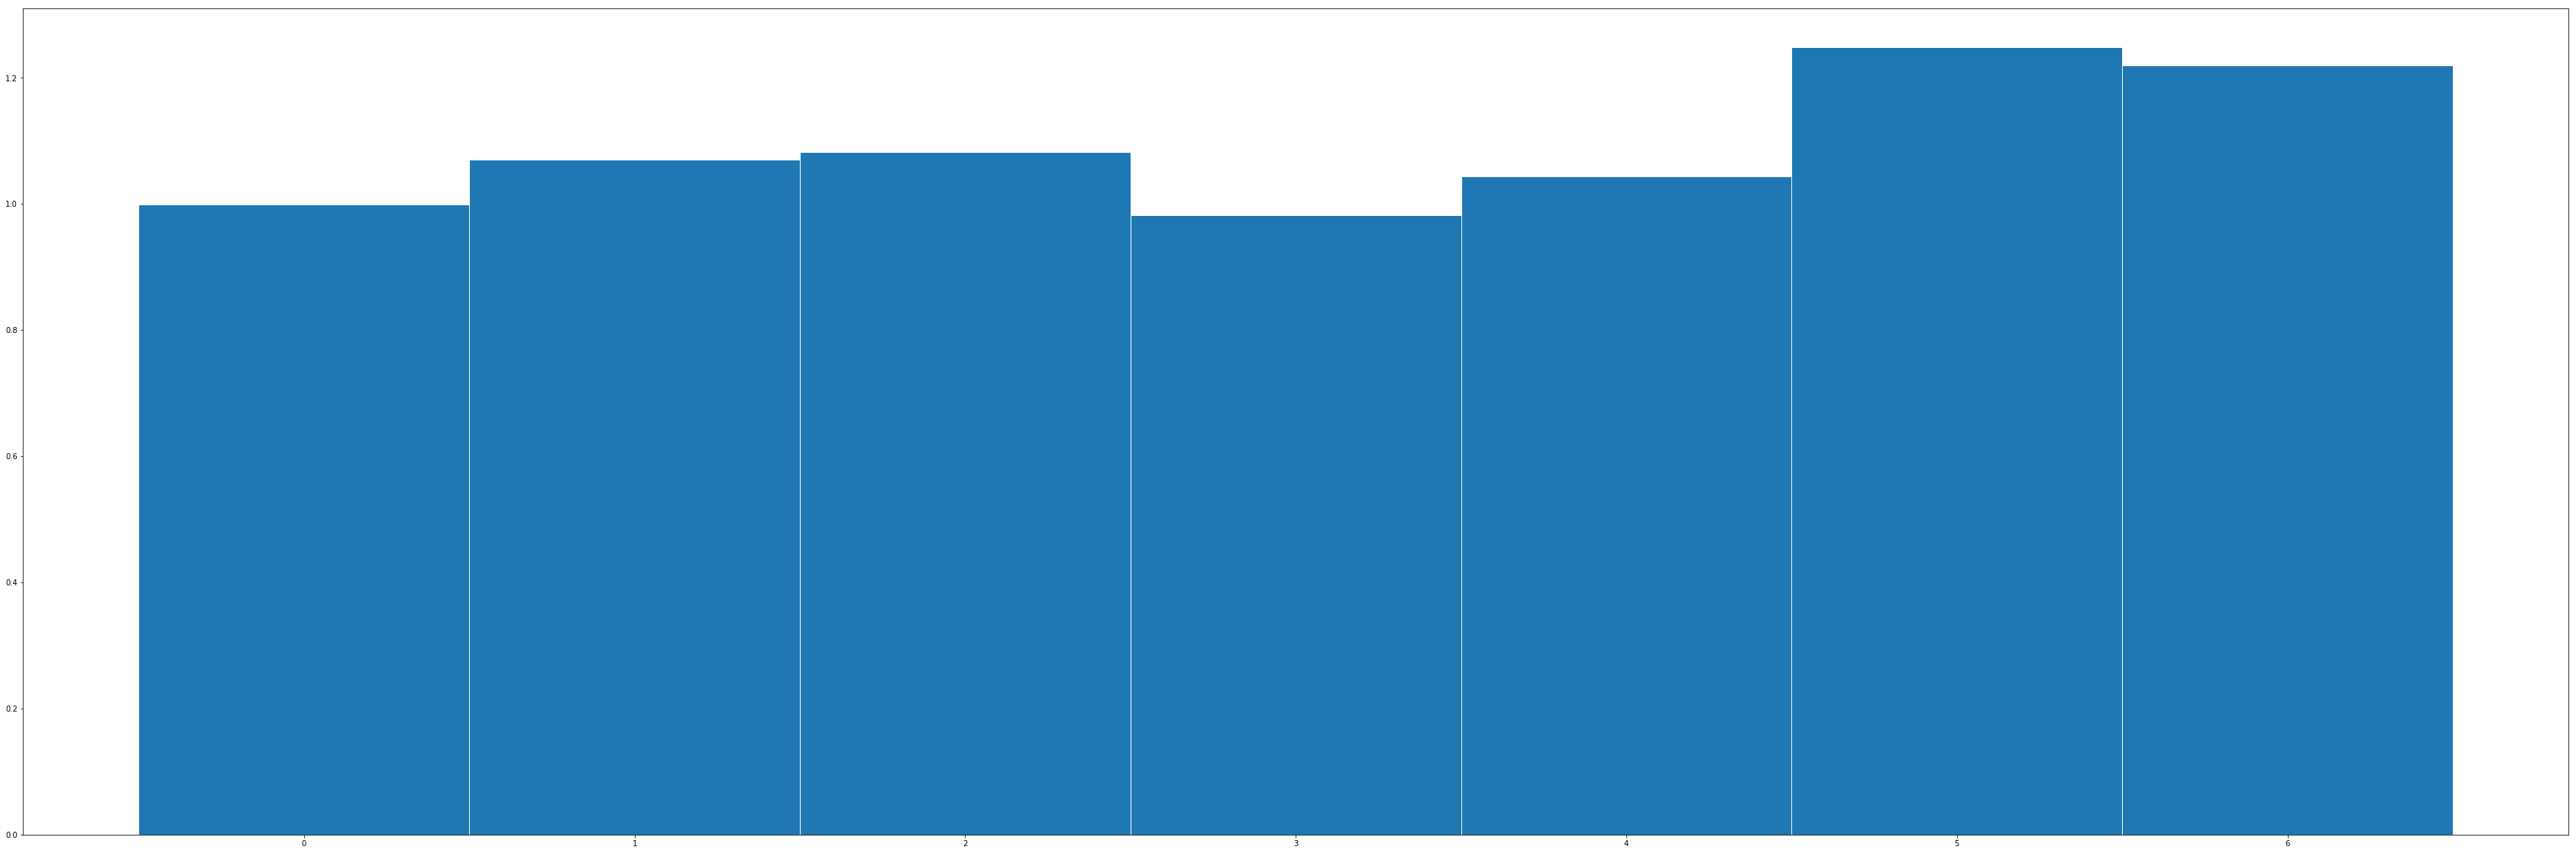

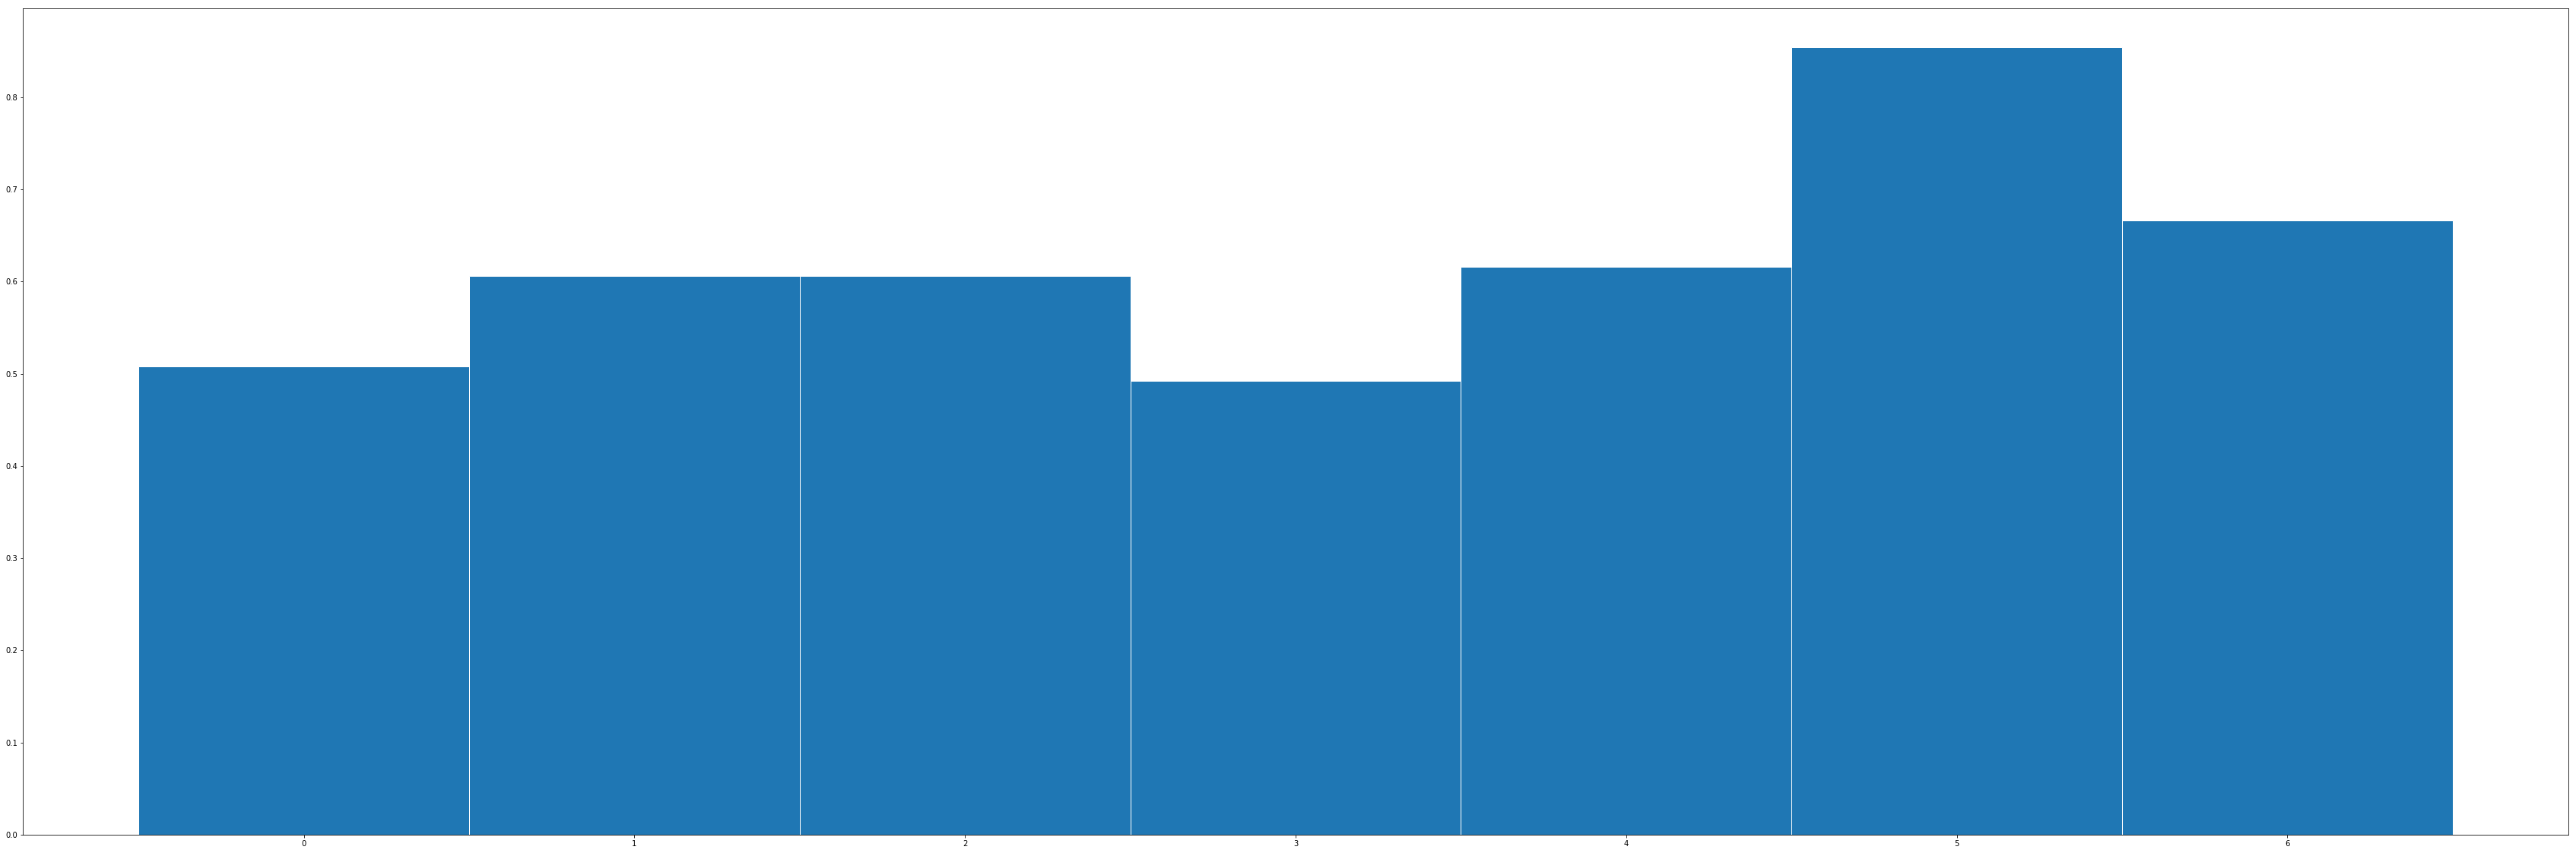

In [11]:
# Let's see if power consumption patterns depend on
# day of the week.

fig, ax = plt.subplots()
pc['day_of_week'] = pc['date'].apply(lambda x: x.weekday())

pc_plot = pc[['date', 'Global_active_power']]
pc_plot['day_of_week'] = pc_plot['date'].apply(lambda x: x.weekday())

pc_plot = pc_plot[['day_of_week', 'Global_active_power']].groupby(['day_of_week']).mean().reset_index().rename(index = str, columns = {"Global_active_power": "mean_active_power"})
pc_plot = pc_plot.merge(pc[['day_of_week', 'Global_active_power']].groupby(['day_of_week']).median().reset_index().rename(index = str, columns = {"Global_active_power": "median_active_power"}), on = 'day_of_week', how = 'inner')

#ax.plot(pc_plot['day_of_week'], pc_plot[['mean_active_power', 'median_active_power']])
plt.rcParams["figure.figsize"] = [60, 20]
plt.bar(list(pc_plot.loc[:, 'day_of_week']), list(pc_plot.loc[:, 'mean_active_power']), width = 1, bottom = None, align = 'center', edgecolor = 'white')
plt.show()

plt.bar(list(pc_plot.loc[:, 'day_of_week']), list(pc_plot.loc[:, 'median_active_power']), width = 1, bottom = None, align = 'center', edgecolor = 'white')
plt.show()
#fig.savefig('day_of_week_power.png')
#fig.show()

# I am going to add days of the week as features. Of course,
# this is suplicating tje information encapsulated in the 
# weekday/weekend feature, but I will just choose between the
# features when I build my model.

pc['Monday'] = [1 if a == 0 else 0 for a in pc['day_of_week']]
pc['Tuesday'] = [1 if a == 1 else 0 for a in pc['day_of_week']]
pc['Wednesday'] = [1 if a == 2 else 0 for a in pc['day_of_week']]
pc['Thursday'] = [1 if a == 3 else 0 for a in pc['day_of_week']]
pc['Friday'] = [1 if a == 4 else 0 for a in pc['day_of_week']]
pc['Saturday'] = [1 if a == 5 else 0 for a in pc['day_of_week']]
pc['Sunday'] = [1 if a == 6 else 0 for a in pc['day_of_week']]




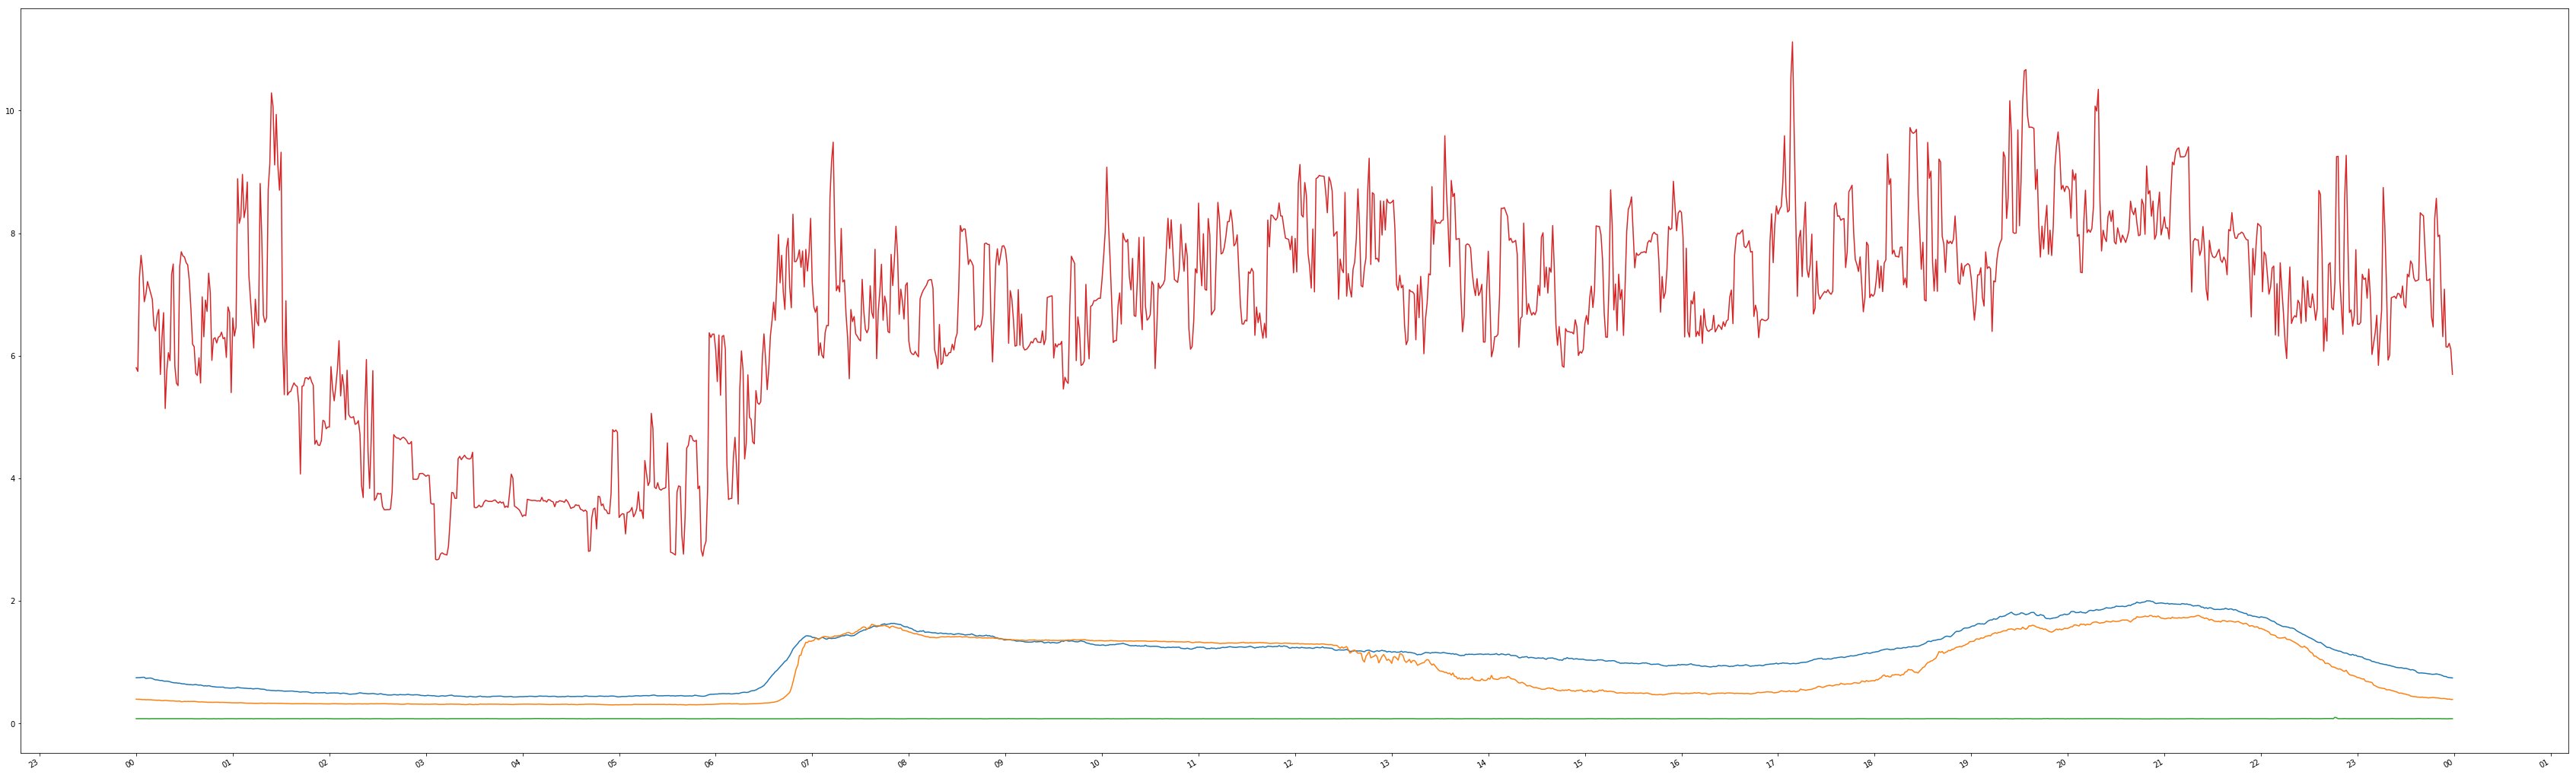

In [13]:
del pc_plot

fig, ax = plt.subplots()

pc_plot = pc[['time', 'Global_active_power']].groupby(['time']).mean().reset_index().rename(index = str, columns = {"Global_active_power": "mean_active_power"})
pc_plot = pc_plot.merge(pc[['time', 'Global_active_power']].groupby(['time']).median().reset_index().rename(index = str, columns = {"Global_active_power": "median_active_power"}), on = 'time', how = 'inner')
pc_plot = pc_plot.merge(pc[['time', 'Global_active_power']].groupby(['time']).min().reset_index().rename(index = str, columns = {"Global_active_power": "min_active_power"}), on = 'time', how = 'inner')
pc_plot = pc_plot.merge(pc[['time', 'Global_active_power']].groupby(['time']).max().reset_index().rename(index = str, columns = {"Global_active_power": "max_active_power"}), on = 'time', how = 'inner')

ax.format_xdata = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.plot(pc_plot['time'], pc_plot[['mean_active_power', 'median_active_power', 'min_active_power', 'max_active_power']])
fig.autofmt_xdate()
plt.rcParams["figure.figsize"] = [60, 20]

fig.savefig('daily_power.png')
fig.show()

# The time of day has an obvious impact on power consumption.
# Power is lowest in the early morning, rises some in the
# late morning, dips in the early afternoon, crests in the
# late afternoon/evening, and drops again late at night.
# For this project, I am going to bin these times by hour. 
# However, in production, I would probably try more minute
# intervals. For my current purposes, this amount of detail
# should be fine.

# Since power consumption through the day is not linear nor
# does it follow any mathematically identifiable relationship,
# I shouldn't just have the hour number as a feature. I could
# create 24 dummy variables, each representing one hour of the
# day. However, this is rather cumbersome. I would try that
# if I had more time to spend on this and to focus more
# on feature selection. As it is, I hope that the value for
# the same hour one day prior should encapsulate the predictive
# power of hour of the day.

# I normally do data science using R, which has the factor datatype,
# which R's data science functions use to turn categorical
# variables into dummy variables. I'm not sure whether python
# functions can do that.



In [15]:
pc['date_hour'] = [datetime.datetime.strptime(str(a.year) + '-' + str(a.month) + '-' + 
                                str(a.day) + ' ' +
                                (str(a.hour) if a.hour >= 10 else '0' + str(a.hour)), 
                                 '%Y-%m-%d %H')
                  for a in pc['timestamp']]
      

In [19]:
pc_final = pc.groupby(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 
                       'date_hour', 'winter', 'spring', 'summer', 'fall', 'jan', 'feb','mar', 'apr', 
                       'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].mean()
pc_final = pc_final.reset_index()

print(list(pc_final['date_hour']) == list(sorted(pc_final['date_hour'])))
pc_final = pc_final.sort_values(by = ['date_hour'])
print(list(pc_final['date_hour']) == list(sorted(pc_final['date_hour'])))

# Everything is in order. Now we just shift the data 24 hours back.

pc_final['measurement_time'] = pc_final['date_hour']
pc_final['target'] = pc_final['Global_active_power']
pc_final[['Global_active_power', 'Global_reactive_power', 'Voltage',
          'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
          'Sub_metering_3', 'measurement_time']] = pc_final[['Global_active_power', 'Global_reactive_power', 'Voltage',
          'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
          'Sub_metering_3', 'measurement_time']].shift(24)

# Now all those values have been shifted back by one day.
# This introduced 24 rows of nan's.

pc_final = pc_final[24:]

# Check to make sure that the vast majority of rows contain data
# that correspond to 24 hours earlier

hour_differences = list(pc_final.apply(lambda x: (x['date_hour'] - x['measurement_time']).seconds / 3600 +
                                       (x['date_hour'] - x['measurement_time']).days * 24, axis = 1))

print(len([a for a in hour_differences if a == 24]))
print(len([a for a in hour_differences if a != 24]))

# We only have 192 rows with the incorrect timeshift.
# This is due to missing data. Since this is less than
# 1% of the data, I will just remove rows that do not have
# the correct time shift. Ideally, I would spend the time
# to correct as many of the rows as possible. However, I
# just don't have time right now.

pc_final = pc_final[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
                     'target', 'winter', 'spring', 'summer', 'fall', 'jan', 'feb', 'mar', 'apr', 
                     'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 
                     'Global_active_power', 'Global_reactive_power', 'Voltage',
                     'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
pc_final = pc_final[[True if a == 24 else False for a in hour_differences]]

# This is the final set of features. Were this real life,
# I would add additional features. For one, I might try to
# add features regarding the forecasted weather of the next
# day. I would also add features for every hour. I would also
# do some more research on factors that affect electricity use, 
# adding whatever outside relevant data that could potentially
# improve my model.

# Normally, the next step would be feature reduction. In the
# hypothetical case I described above, this would be more
# important because the dataset would contain more than double
# the features. I'd try different techniques and build models
# with each technique. LASSO and principal components are
# definitely methods to put to use. Generally, my preferred 
# method is PCA.

# Since I have already spent over 3.5 hours and  intentionally
# refrained from creating too many features, I will skip
# feature reduction and move directly to training and evaluating
# some models.

train, test = ms.train_test_split(pc_final, test_size = 0.25)

train.to_csv('pc_train.csv', index = False)
test.to_csv('pc_test.csv', index = False)


False
True
33952
192


               Date      Time  Global_active_power  Global_reactive_power  \
0        16/12/2006  17:24:00                4.216                  0.418   
1        16/12/2006  17:25:00                5.360                  0.436   
2        16/12/2006  17:26:00                5.374                  0.498   
3        16/12/2006  17:27:00                5.388                  0.502   
4        16/12/2006  17:28:00                3.666                  0.528   
5        16/12/2006  17:29:00                3.520                  0.522   
6        16/12/2006  17:30:00                3.702                  0.520   
7        16/12/2006  17:31:00                3.700                  0.520   
8        16/12/2006  17:32:00                3.668                  0.510   
9        16/12/2006  17:33:00                3.662                  0.510   
10       16/12/2006  17:34:00                4.448                  0.498   
11       16/12/2006  17:35:00                5.412                  0.470   